In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException

In [2]:
driver = webdriver.Chrome()
driver.maximize_window()

In [10]:
driver.get('https://b2run-iframe.maxfunsports.com/event/view?id=3202')
# Enter the first page of the competition results
driver.find_element(by=By.XPATH, value='//*[@id="w0"]/table/tbody/tr[1]/td/a').click()

In [11]:
# Select the team to do the analysis for
team = 'United Internet'
filter = True

if filter:
    # Filter the table for team employees
    driver.find_element(by=By.XPATH, value='//*[@id="w0-filters"]/td[5]/input').send_keys(team + Keys.ENTER)
    print('Filtered participants table for {}'.format(team))

Filtered participants table for United Internet


In [12]:
participants = []

try:
    print('Reading participants table and extracting rows')
    # Loop through batches of rows until there are non left
    while True:
        table = driver.find_element(by=By.XPATH, value='//*[@id="w0"]/table/tbody')
        rows = table.find_elements(by=By.TAG_NAME, value='tr')
        for row in rows:
            # Extract the columns in each row
            cols = row.find_elements(by=By.TAG_NAME, value='td')
            # Get the link to the page where more info about the participant is available
            link_to_detailed_info = cols[3].find_element(by=By.TAG_NAME, value='a').get_attribute('href')
            # Parse the page html using BeautifulSoup
            response = requests.get(link_to_detailed_info)
            soup = BeautifulSoup(response.content, 'html.parser')
            # Extract the gender
            gender = soup.find(id='w1').find_all('td')[1]
            # Expand the columns
            cols.append(gender)
            # Extract the values of each column
            participants.append(list(map(lambda x: x.text, cols[2:])))
        # Go to the next batch of rows (if any) 
        driver.find_element(by=By.CSS_SELECTOR, value='#w0 > ul > li.next > a').click()
except NoSuchElementException:
    print('We reached the bottom of the table')

Reading participants table and extracting rows
We are at the bottom of the table


In [13]:
print('There are {} participants from {}'.format(len(participants), team))

There are 202 participants from United Internet


In [21]:
COLUMNS = [
    'first_name', 'last_name',
    'team', 'category',
    'gross_time', 'net_time',
    'gender'
]

df = pd.DataFrame(participants, columns=COLUMNS)
df['gross_time'] = pd.to_timedelta(df['gross_time'])
df['net_time'] = pd.to_timedelta(df['net_time'])

# Get the net time in seconds
df['net_time_seconds'] = df['net_time'].dt.seconds

selected_team = df[df['team'] == team].reset_index(drop=True)

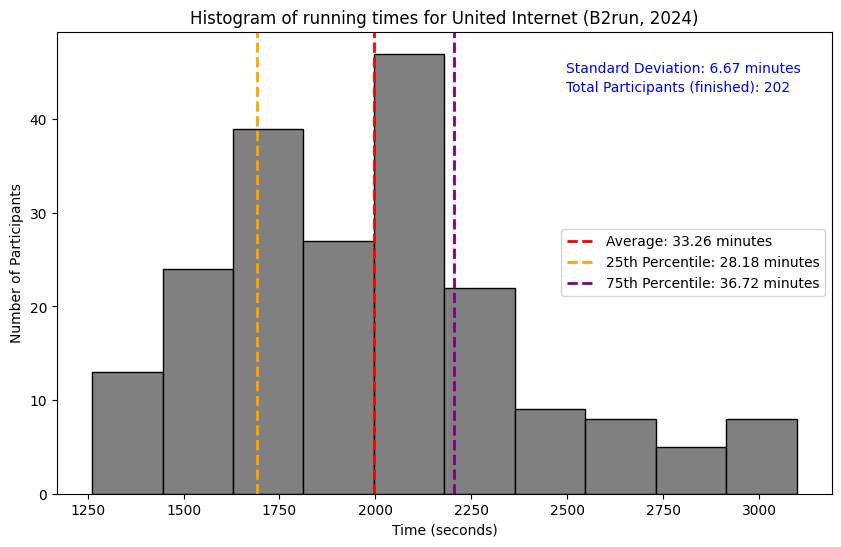

In [23]:
# Adjust the plot parameters based on the selected team's values 

times_in_seconds = selected_team['net_time_seconds'].values

mean_time = np.mean(times_in_seconds)
mean_time = np.mean(times_in_seconds)
std_dev = np.std(times_in_seconds)
max_time = np.max(times_in_seconds)
percentile_25 = np.percentile(times_in_seconds, 25)
percentile_75 = np.percentile(times_in_seconds, 75)
total_participants = len(times_in_seconds)

plt.figure(figsize=(10, 6))
plt.hist(times_in_seconds, bins=10, color='gray', edgecolor='black')
plt.axvline(mean_time, color='red', linestyle='dashed', linewidth=2, label=f'Average: {mean_time / 60:.2f} minutes')
plt.axvline(percentile_25, color='orange', linestyle='dashed', linewidth=2, label=f'25th Percentile: {percentile_25 / 60:.2f} minutes')
plt.axvline(percentile_75, color='purple', linestyle='dashed', linewidth=2, label=f'75th Percentile: {percentile_75 / 60:.2f} minutes')

# Add standard deviation
plt.text(max_time - 600, 45, f'Standard Deviation: {std_dev / 60:.2f} minutes', color='blue')
plt.text(max_time - 600, 43, f'Total Participants (finished): {total_participants}', color='blue')
# Adding titles and labels
plt.title(f'Histogram of running times for {team} (B2run, 2024)')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Participants')
# Show the plot
plt.legend()
plt.show()

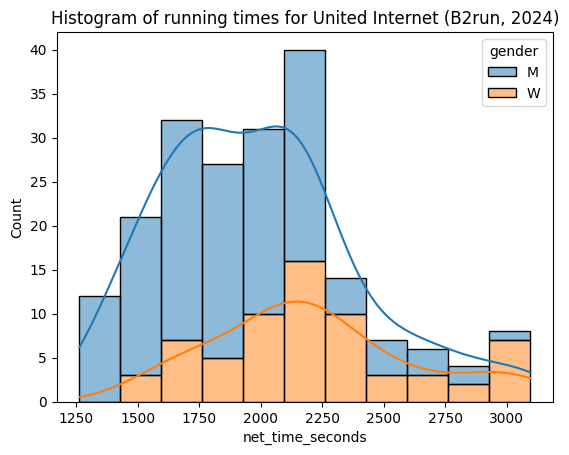

In [24]:
sns.histplot(
    data=selected_team, x='net_time_seconds',
    hue='gender', multiple='stack', kde=True
).set_title(f'Histogram of running times for {team} (B2run, 2024)');

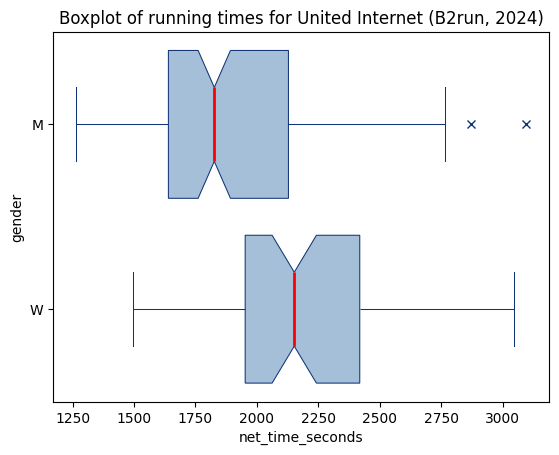

In [25]:
sns.boxplot(
    data=selected_team, x='net_time_seconds',
    y='gender', color='0.8', linecolor='#137',
    linewidth=.75, notch=True,
    medianprops={'color': 'r', 'linewidth': 2},
    flierprops={'marker': 'x'},
    boxprops={'facecolor': (.3, .5, .7, .5)}
).set_title(f'Boxplot of running times for {team} (B2run, 2024)');